# Lightning Review of Class Imbalance Techniques

There is no definitive answer to the question: What should one do when dealing with imbalanced data?
The answer will depend on the data in question.
Here are a few approaches one might try to improve performance on an unbalanced dataset.
It is common to discuss these topics in a job interview.

## Metrics to use

Using the accuracy of a classifier as a metric can be misleading because a model could predict that every sample belongs to the majority class and still achieve high accuracy if the data is imbalanced enough.
For this reason accuracy is not a recommended metric in this setting.
The ROC curve is a good general purpose metric, providing information about the true and false positive rates across a range of thresholds, and the area under the ROC curve (AUC) is a good general purpose, single number metric.
The AUC score focuses on true negatives, which are less informative than false positives and false negatives when the data is imbalanced.
Therefore we recommend the precision-recall curve as the metric to use on imbalanced data, or the average precision score if a single number if preferred.

## Balance the training set

One might also try to balance the training set either by undersampling the majority class, oversampling the minority class, or by synthesizing new minority examples.
Oversampling runs the risk of overfitting, and training with oversampling takes longer because of the additional data.
For these reasons we will focus on undersampling in this work.
In particular, we will use random undersampling to create a balanced random forest, and balanced batches to feed into a neural network.
The algorithm for how the balanced random forest makes classifications is as follows: 
![](images/ImbalancedClasses_fig9.png)
Image Credit: [Tom Fawcett, Silicon Valley Data Science](https://www.svds.com/learning-imbalanced-classes/).
It is the second step of this process that is absence in a standard random forest.
Even if this does not lead to a gain in performance training is faster with this approach because less data is used.

## Change the algorithm

Lastly, one might consider making changes to the algorithms being used.
A simple example of this is if a metric such as precision, recall, or F1 score is being used, its decision threshold can be optimized to maximize performance.
Another approach is to adjust the class weights in the loss function, creating a larger penalty for misclassifying an example from the minority class.
Consider the cross entropy loss function used for binary classification
\begin{equation}
L = - y \log(p) - (1 - y) \log(1 - p) ,
\end{equation}
where $y$ is the ground-truth class with $y = 1$ for the LL class, and $p$ is the model's estimated probability that a given event belong to the LL class.
Weighting the loss function can be implemented as follows
\begin{equation}
L = - \alpha\, y \log(p) - (1 - \alpha) (1 - y) \log(1 - p) ,
\end{equation}
where the class weight hyperparameter, $\alpha$, takes values between 0 and 1 in this notation.
(For tree based models, such as random forest, our baseline loss function is the Gini impurity not the cross entropy. However the logic of modifying the baseline loss function is the same.)
[arxiv:1708.02002](https://arxiv.org/abs/1708.02002) took this one step further, introducing the _focal loss_ function
\begin{equation}
L = - \alpha\, y (1 - p)^{\gamma} \log(p) - (1 - \alpha) (1 - y) p^{\gamma} \log(1 - p) ,
\end{equation}
where the focusing parameter, $\gamma > 0$, puts the focus on hard, misclassified examples.
In doing so it down weights the easy-to-classify negatives that can overwhelm a model during training in the presence of class imbalance. 

# imbalanced-learn

There is a software package, [imbalanced-learn](https://imbalanced-learn.org/en/stable/index.html), dedicated to the task of learning from imbalanced data.

```
conda install -c conda-forge imbalanced-learn
```

# Case Study

In [5]:
from imblearn.datasets import fetch_datasets
from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from imblearn.ensemble import BalancedRandomForestClassifier

Use a utility from `imblearn` to fetch the 27 datasets used in this demonstration

In [2]:
datasets = fetch_datasets('datasets/')

We consider 3 models:
- Random Forest
- Weighted Random Forest - loss function has weights associated with each class. We use the values of y to automatically adjust weights inversely proportional to class frequencies in the input data as n_samples / (n_classes * np.bincount(y))
- Balanced Random Forest - randomly under-samples each boostrap sample to balance it.

Each forest has 100 trees with a maximum depth of 5. No hyperparameter tuning has been performed. Below are dictionaries to store the results for each model

In [33]:
rfc_results = dict()
wrfc_results = dict()
brfc_results = dict()

Run our three models on the 27 datasets with a five-fold cross validation, scoring them on average precision

In [40]:
def cv_analysis(dataset):
    name = dataset['DESCR']
    X = dataset['data']
    y = dataset['target']
    print(name + '\n----------')
    
    rfc = RandomForestClassifier(n_estimators=100,
                                 max_depth=5)
    rfc_results[name] = cross_validate(rfc,
                                       X,
                                       y,
                                       scoring='average_precision',
                                       cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=10),
                                       return_train_score=False)
    print('Random Forest - average precision: %0.3f +/- %0.3f'
          %(np.mean(rfc_results[name]['test_score']), np.std(rfc_results[name]['test_score'])))
    
    wrfc = RandomForestClassifier(n_estimators=100,
                                  max_depth=5,
                                  class_weight='balanced')
    wrfc_results[name] = cross_validate(wrfc,
                                        X,
                                        y,
                                        scoring='average_precision',
                                        cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=10),
                                        return_train_score=False)
    print('Weighted Random Forest - average precision: %0.3f +/- %0.3f'
          %(np.mean(wrfc_results[name]['test_score']), np.std(wrfc_results[name]['test_score']))) 

    brfc = BalancedRandomForestClassifier(n_estimators=100,
                                          max_depth=5)
    brfc_results[name] = cross_validate(brfc,
                                        X,
                                        y,
                                        scoring='average_precision',
                                        cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=10),
                                        return_train_score=False)
    print('Balanced Random Forest - average precision: %0.3f +/- %0.3f'
          %(np.mean(brfc_results[name]['test_score']), np.std(brfc_results[name]['test_score'])))
    print('\n')

Printing mean +/- standard deviation of the cross validation

In [42]:
for dataset in datasets:
    cv_analysis(datasets[dataset])

ecoli
----------
Random Forest - average precision: 0.734 +/- 0.070
Weighted Random Forest - average precision: 0.631 +/- 0.135
Balanced Random Forest - average precision: 0.651 +/- 0.106


optical_digits
----------
Random Forest - average precision: 0.936 +/- 0.014
Weighted Random Forest - average precision: 0.927 +/- 0.023
Balanced Random Forest - average precision: 0.931 +/- 0.027


satimage
----------
Random Forest - average precision: 0.709 +/- 0.028
Weighted Random Forest - average precision: 0.694 +/- 0.026
Balanced Random Forest - average precision: 0.691 +/- 0.030


pen_digits
----------
Random Forest - average precision: 0.988 +/- 0.003
Weighted Random Forest - average precision: 0.989 +/- 0.002
Balanced Random Forest - average precision: 0.990 +/- 0.004


abalone
----------
Random Forest - average precision: 0.341 +/- 0.034
Weighted Random Forest - average precision: 0.334 +/- 0.029
Balanced Random Forest - average precision: 0.342 +/- 0.048


sick_euthyroid
----------
Rando

In [95]:
rfc_mean = np.array([np.mean(rfc_results[dataset]['test_score']) for dataset in datasets])
rfc_std = np.array([np.std(rfc_results[dataset]['test_score']) for dataset in datasets])
wrfc_mean = np.array([np.mean(wrfc_results[dataset]['test_score']) for dataset in datasets])
wrfc_std = np.array([np.std(wrfc_results[dataset]['test_score']) for dataset in datasets])
brfc_mean = np.array([np.mean(brfc_results[dataset]['test_score']) for dataset in datasets])
brfc_std = np.array([np.std(brfc_results[dataset]['test_score']) for dataset in datasets])

Plotting the results:
- Fig.1 (9 of 27 cases) - datasets where both weighting and balancing improve the average precision
- Fig.2 (12 of 27 cases) - datasets where neither weighting nor balancing improve the average precision
- Fig.3 (6 of 27 cases) - datasets where each weighting or balancing improve the average precision

The improvement is determined based on the mean value of the cross validation. The black error bars give the standard deviation of the cross validation

In [47]:
import matplotlib.pyplot as plt
%matplotlib notebook

<IPython.core.display.Javascript object>


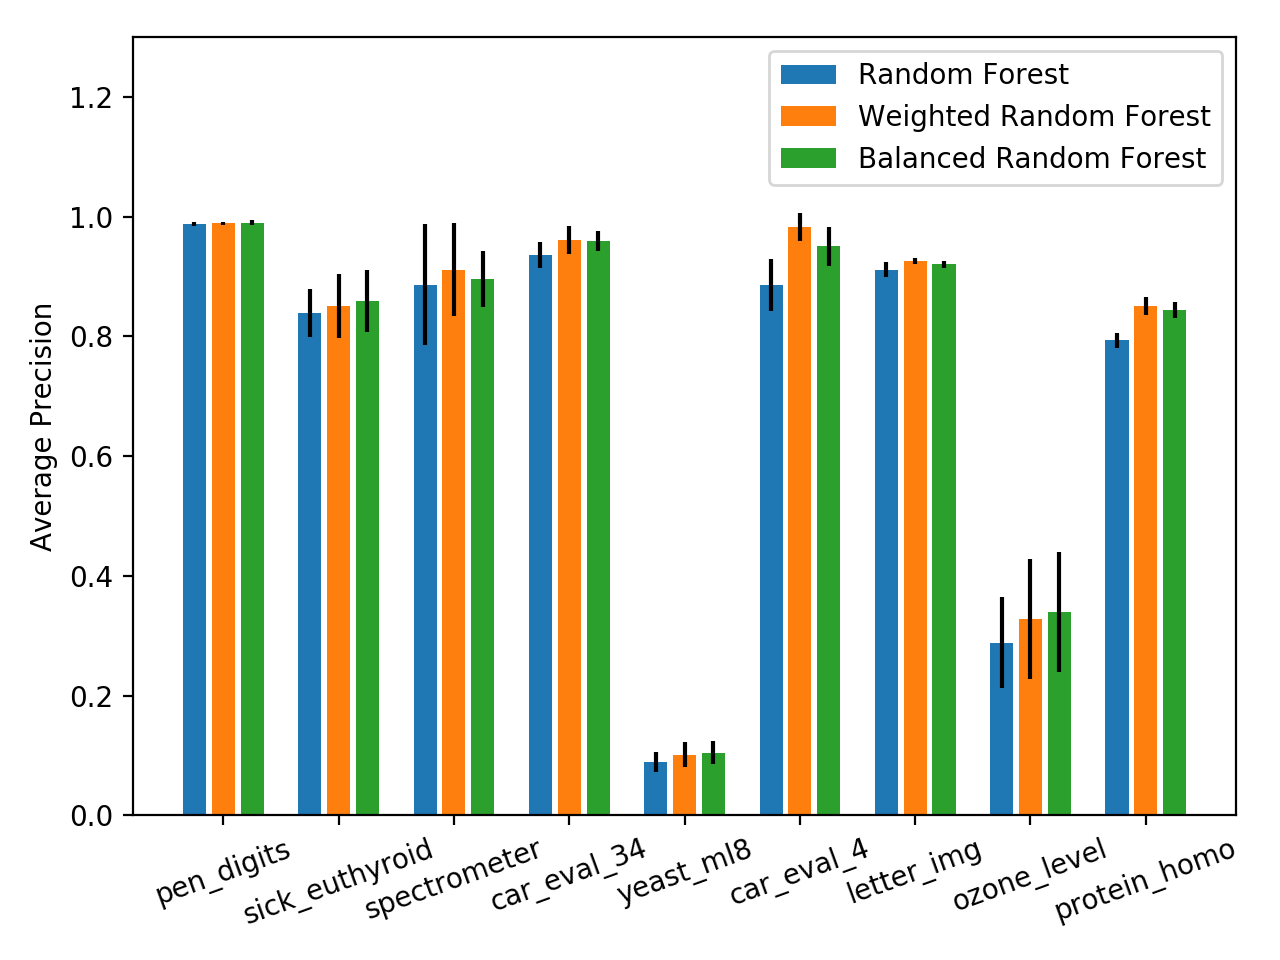

In [155]:
plt.figure(1)

improves = (wrfc_mean > rfc_mean) & (brfc_mean > rfc_mean)

plt.bar(range(0, 4*np.sum(improves)+0, 4),
        rfc_mean[improves],
        yerr=rfc_std[improves],
        label='Random Forest')
plt.bar(range(1, 4*np.sum(improves)+1, 4),
        wrfc_mean[improves],
        yerr=wrfc_std[improves],
        label='Weighted Random Forest')
plt.bar(range(2, 4*np.sum(improves)+2, 4),
        brfc_mean[improves],
        yerr=brfc_std[improves],
        label='Balanced Random Forest')

plt.xticks(range(1, 4*np.sum(improves)+1, 4),
           np.array(list(rfc_results.keys()))[improves],
           rotation=20)
plt.ylabel('Average Precision')
plt.ylim(0.0, 1.3)
plt.legend()
plt.tight_layout()
plt.show()

<IPython.core.display.Javascript object>


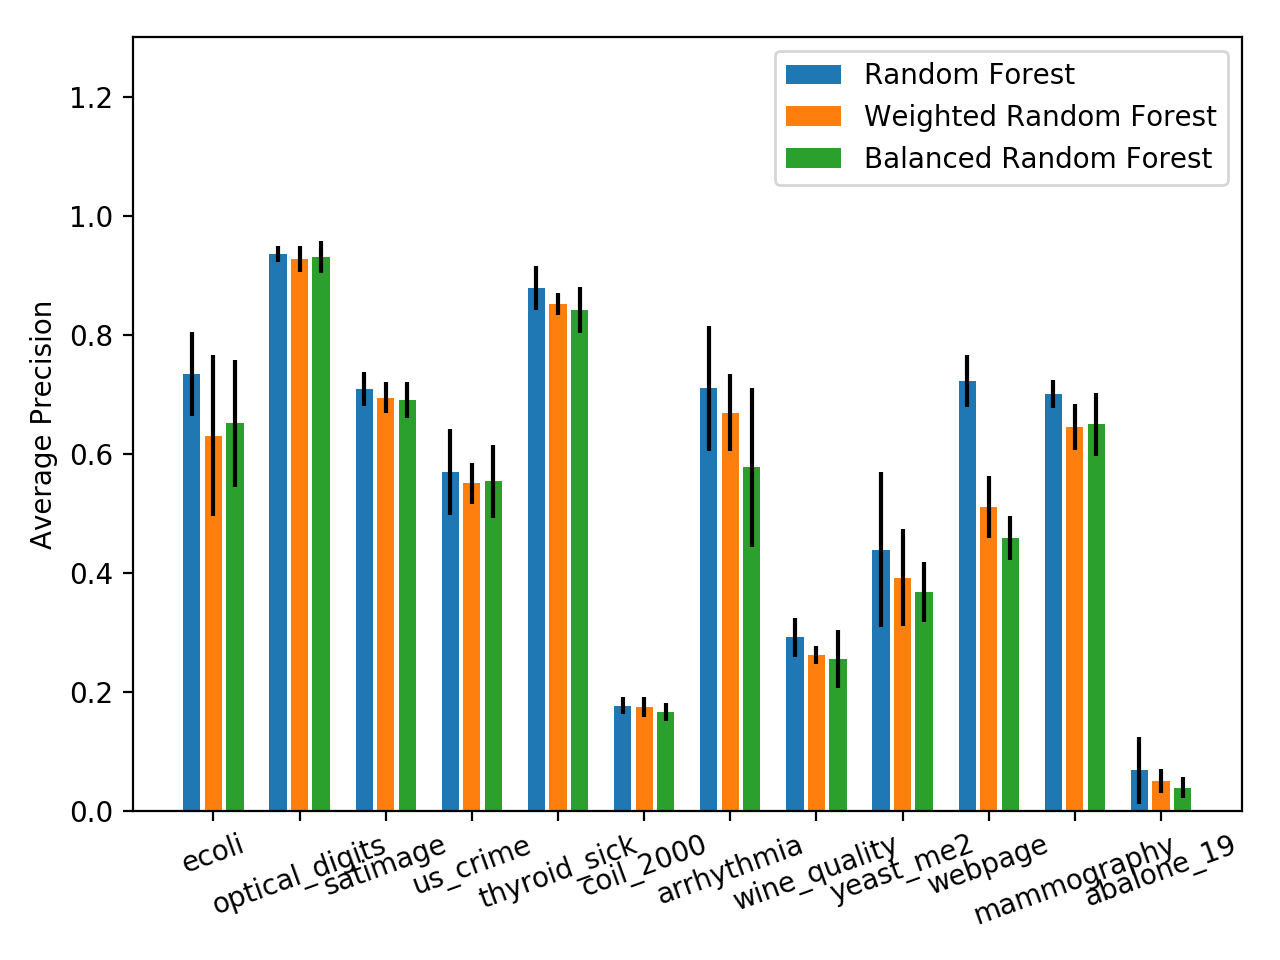

In [149]:
plt.figure(2)

no_impro = (wrfc_mean < rfc_mean) & (brfc_mean < rfc_mean)

plt.bar(range(0, 4*np.sum(no_impro)+0, 4),
        rfc_mean[no_impro],
        yerr=rfc_std[no_impro],
        label='Random Forest')
plt.bar(range(1, 4*np.sum(no_impro)+1, 4),
        wrfc_mean[no_impro],
        yerr=wrfc_std[no_impro],
        label='Weighted Random Forest')
plt.bar(range(2, 4*np.sum(no_impro)+2, 4),
        brfc_mean[no_impro],
        yerr=brfc_std[no_impro],
        label='Balanced Random Forest')

plt.xticks(range(1, 4*np.sum(no_impro)+1, 4),
           np.array(list(rfc_results.keys()))[no_impro],
           rotation=20)
plt.ylabel('Average Precision')
plt.ylim(0.0, 1.3)
plt.legend()
plt.tight_layout()
plt.show()

<IPython.core.display.Javascript object>


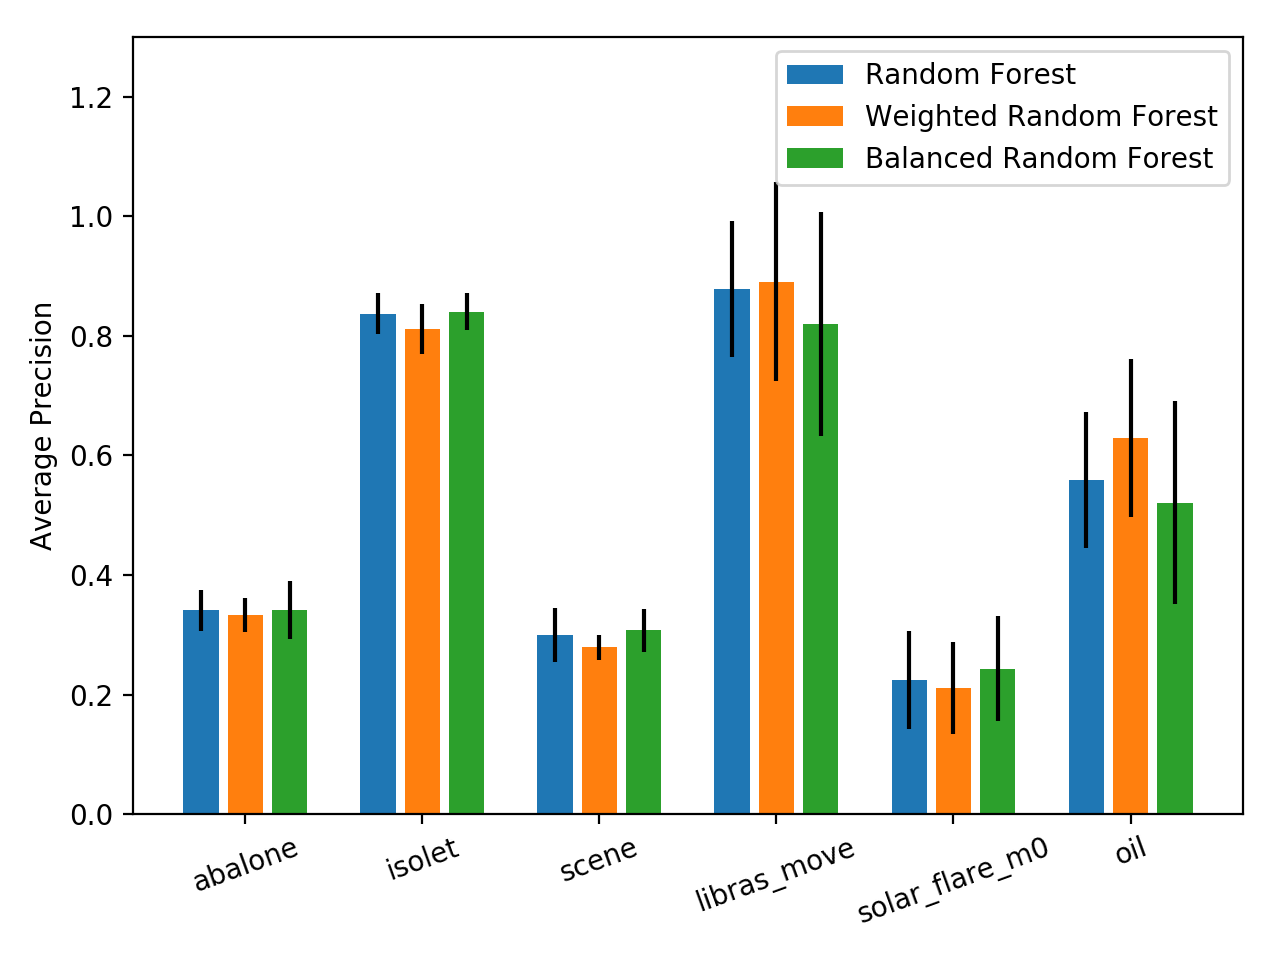

In [153]:
plt.figure(3)

no_impro = (wrfc_mean > rfc_mean) ^ (brfc_mean > rfc_mean)

plt.bar(range(0, 4*np.sum(no_impro)+0, 4),
        rfc_mean[no_impro],
        yerr=rfc_std[no_impro],
        label='Random Forest')
plt.bar(range(1, 4*np.sum(no_impro)+1, 4),
        wrfc_mean[no_impro],
        yerr=wrfc_std[no_impro],
        label='Weighted Random Forest')
plt.bar(range(2, 4*np.sum(no_impro)+2, 4),
        brfc_mean[no_impro],
        yerr=brfc_std[no_impro],
        label='Balanced Random Forest')

plt.xticks(range(1, 4*np.sum(no_impro)+1, 4),
           np.array(list(rfc_results.keys()))[no_impro],
           rotation=20)
plt.ylabel('Average Precision')
plt.ylim(0.0, 1.3)
plt.legend()
plt.tight_layout()
plt.show()